In [1]:
# In Class Lab 9


# G. Besla 
# with code from R. Hoffman, R. Li and E Patel


# import modules
import numpy as np
import astropy.units as u
from astropy.constants import G

# import plotting modules
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# my modules
from ReadFile import Read
from CenterOfMass import CenterOfMass
from MassProfile import MassProfile

# for contours
import scipy.optimize as so


# Lab 9   Contour Plots and Spiral Arms

In this lab you will extend Lab 7 to:

1) Using High Res Data Files 

2) Adding Vcirc in cylindrical coords

3) Tracking particles across snapshots

4) Velocity Dispersion and Msigma Relation


In [2]:
# Code for plotting contours
#from https://gist.github.com/adrn/3993992


def find_confidence_interval(x, pdf, confidence_level):
    return pdf[pdf > x].sum() - confidence_level

# Info about **kwargs, *args 
#https://book.pythontips.com/en/latest/args_and_kwargs.html

def density_contour(xdata, ydata, nbins_x, nbins_y, ax=None, **contour_kwargs):
    """ Create a density contour plot.
    Parameters
    ----------
    xdata : numpy.ndarray
    ydata : numpy.ndarray
    nbins_x : int
        Number of bins along x dimension
    nbins_y : int
        Number of bins along y dimension
    ax : matplotlib.Axes (optional)
        If supplied, plot the contour to this axis. Otherwise, open a new figure
    contour_kwargs : dict
        kwargs to be passed to pyplot.contour()
        i.e. unknown number of keywords 
        
    Example Usage
    -------------
     density_contour(x pos, y pos, contour res, contour res, axis, colors for contours)
     e.g.:
     density_contour(xD, yD, 80, 80, ax=ax, 
             colors=['red','orange', 'yellow', 'orange', 'yellow'])

    """

    H, xedges, yedges = np.histogram2d(xdata, ydata, bins=(nbins_x,nbins_y), normed=True)
    # NOTE : if you are using the latest version of python, in the above: 
    # instead of normed=True, use density=True
    
    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,nbins_x))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbins_y,1))

    pdf = (H*(x_bin_sizes*y_bin_sizes))  
    
    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    Z = pdf.T  # transpose of distribution fxn
    fmt = {}
    
    ### Adjust Here #### 
    
    # Contour Levels Definitions
    one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.68))
    #brentq is root finding method
    two_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.95))
    three_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.99))
    
    # You might need to add a few levels
    # I added a few between 1 and 2 sigma to better highlight the spiral arm
    one_sigma1 = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.80))
    one_sigma2 = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.90))

    # Array of Contour levels. Adjust according to the above
    levels = [one_sigma, one_sigma1, one_sigma2, two_sigma, three_sigma][::-1]
    
    # contour level labels  Adjust accoding to the above.
    strs = ['0.68', '0.8','0.9','0.95', '0.99'][::-1]

    
    ###### 
    
    if ax == None:
        contour = plt.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)
        for l, s in zip(contour.levels, strs):
            fmt[l] = s
        plt.clabel(contour, contour.levels, inline=True, fmt=fmt, fontsize=12)

    else:
        contour = ax.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)
        for l, s in zip(contour.levels, strs):
            fmt[l] = s
        ax.clabel(contour, contour.levels, inline=True, fmt=fmt, fontsize=12)
    
    return contour

Use the CenterOfMass code to compute the positions and velocities of all particles in M31's disk relative to its center of mass position and motion.

In [3]:
# Create a COM of object for M31 Disk (particle type=2) Using Code from Homework 4
COMD = CenterOfMass("M31_000_HighRes.txt",2)

In [4]:
# Compute COM of M31 using disk particles
COMP = COMD.COM_P(0.1)
COMV = COMD.COM_V(COMP[0],COMP[1],COMP[2])

In [5]:
# Determine positions of disk particles relative to COM 
xD = COMD.x - COMP[0].value 
yD = COMD.y - COMP[1].value 
zD = COMD.z - COMP[2].value 

# total magnitude
rtot = np.sqrt(xD**2 + yD**2 + zD**2)

# Determine velocities of disk particles relatiev to COM motion
vxD = COMD.vx - COMV[0].value 
vyD = COMD.vy - COMV[1].value 
vzD = COMD.vz - COMV[2].value 

# total velocity 
vtot = np.sqrt(vxD**2 + vyD**2 + vzD**2)

# Arrays for r and v 
r = np.array([xD,yD,zD]).T # transposed for the Rotate Function later
v = np.array([vxD,vyD,vzD]).T

# Part A

Utilize the below code to rotate the M31 disk and plot it edge on and face on.

What is the sense of rotation of M31 ? 

In [6]:

def RotateFrame(posI,velI):
    """a function that will rotate the position and velocity vectors
    so that the disk angular momentum is aligned with z axis. 
    
    PARAMETERS
    ----------
        posI : `array of floats`
             3D array of positions (x,y,z)
        velI : `array of floats`
             3D array of velocities (vx,vy,vz)
             
    RETURNS
    -------
        pos: `array of floats`
            rotated 3D array of positions (x,y,z) 
            such that disk is in the XY plane
        vel: `array of floats`
            rotated 3D array of velocities (vx,vy,vz) 
            such that disk angular momentum vector
            is in the +z direction 
    """
    
    # compute the angular momentum
    L = np.sum(np.cross(posI,velI), axis=0)
    
    # normalize the angular momentum vector
    L_norm = L/np.sqrt(np.sum(L**2))


    # Set up rotation matrix to map L_norm to z unit vector 
    # (disk in xy-plane)
    
    # z unit vector
    z_norm = np.array([0, 0, 1])
    
    # cross product between L and z
    vv = np.cross(L_norm, z_norm)
    s = np.sqrt(np.sum(vv**2))
    
    # dot product between L and z 
    c = np.dot(L_norm, z_norm)
    
    # rotation matrix
    I = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    v_x = np.array([[0, -vv[2], vv[1]], [vv[2], 0, -vv[0]], [-vv[1], vv[0], 0]])
    R = I + v_x + np.dot(v_x, v_x)*(1 - c)/s**2

    # Rotate coordinate system
    pos = np.dot(R, posI.T).T
    vel = np.dot(R, velI.T).T
    
    return pos, vel


In [7]:

# compute the rotated position and velocity vectors
rn, vn = RotateFrame(r,v)


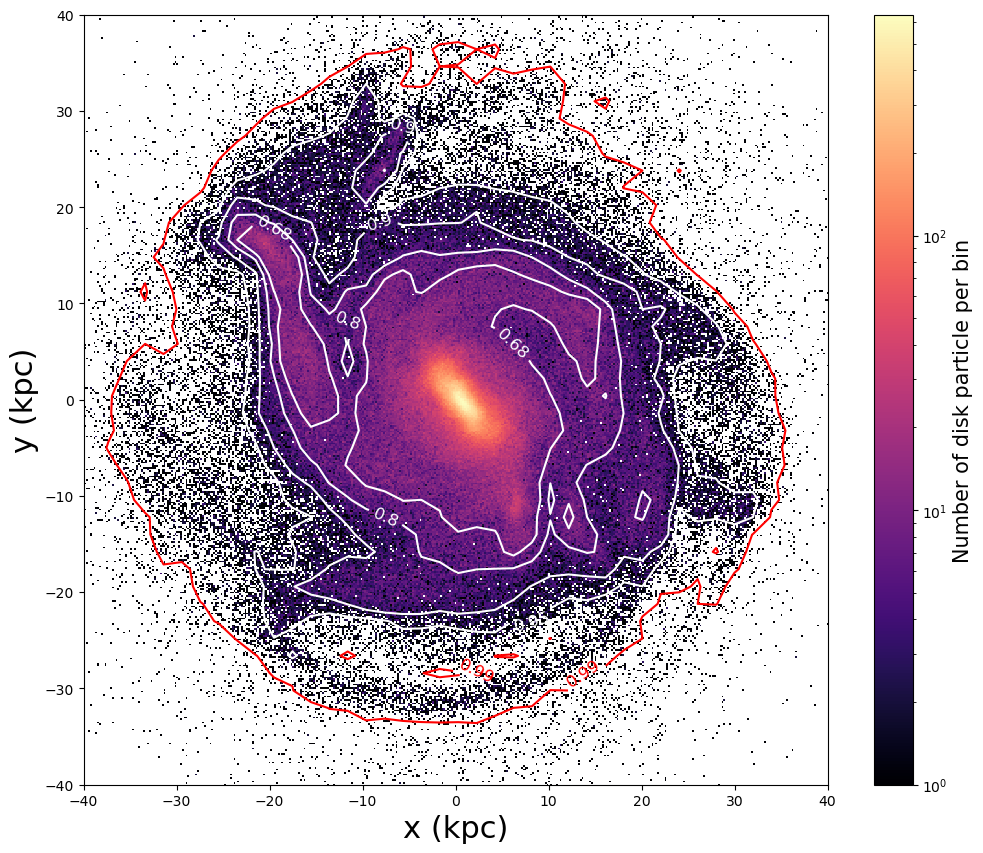

In [8]:
# Rotated M31 Disk - FACE ON

# M31 Disk Density 
fig, ax= plt.subplots(figsize=(12, 10))

# plot the particle density for M31 
# can modify bin number (bin =100 smoothest)
plt.hist2d(rn[:,0], rn[:,1], bins=800, norm=LogNorm(), cmap='magma')
cbar = plt.colorbar()
cbar.set_label("Number of disk particle per bin", fontsize=15)


# Add axis labels
plt.xlabel('x (kpc)', fontsize=22)
plt.ylabel('y (kpc)', fontsize=22)

#set axis limits
plt.ylim(-40,40)
plt.xlim(-40,40)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# make the contour plot
# x pos, y pos, contour res, contour res, axis, colors for contours.
density_contour(rn[:,0], rn[:,1], 80, 80, ax=ax, 
                colors=['red','white', 'white', 'white', 'white'])

plt.savefig('Lab9_FaceOn_Density.png')

If the arms are trailing, then the disk should be rotating towards  NEGATIVE Y  along NEGATIVE X  (CCW)

you could compute the pitch angle of the spiral arm by comparing to a circular orbit at the tangent point

# Part B : Kinematics

In [9]:
# a)  Create a mass profile object for the Milky Way
# using solution to Homework 5
M31 = MassProfile("M31",0)

In [10]:
# define an array of radii
r = np.arange(0.01,40,0.1)

In [11]:
# Create the circular velocity profile
Vcirc = M31.circularVelocityTotal(r)

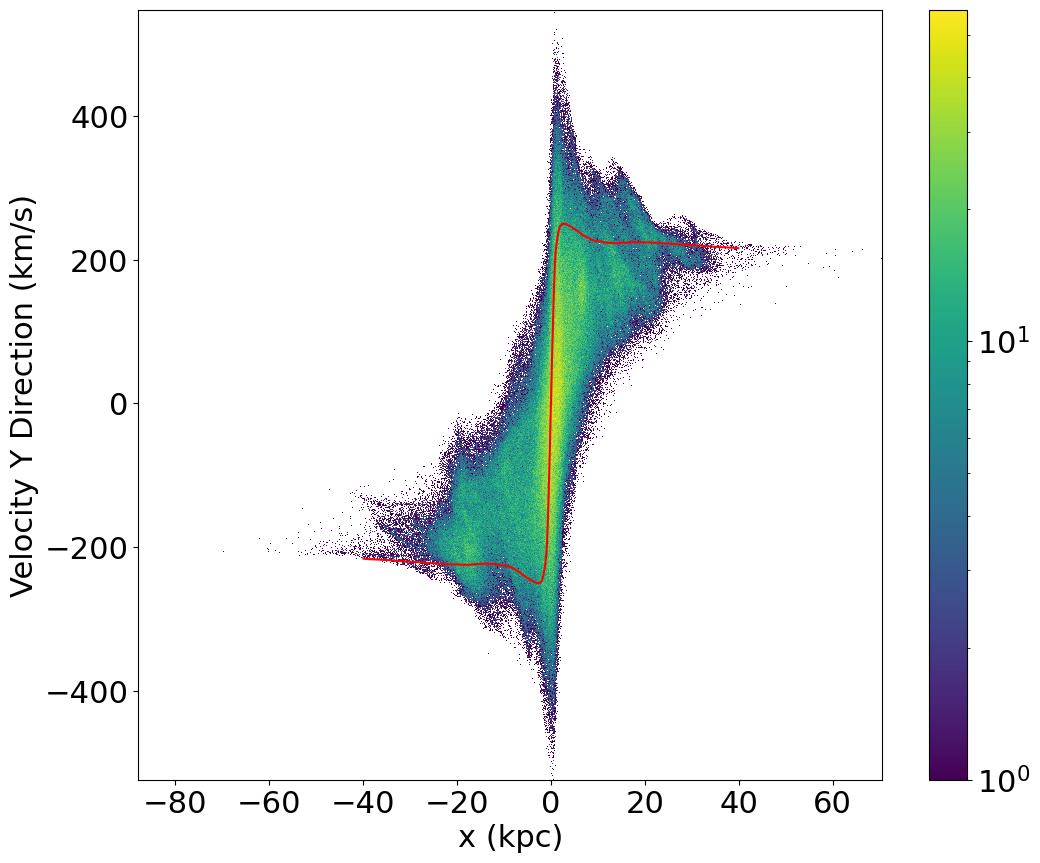

In [12]:
# Make a phase diagram
# MW Disk Velocity Field edge on.

fig = plt.figure(figsize=(12,10))
ax = plt.subplot(111)

# looking at MW edge on along x axis, vy is line of sight velocity

plt.hist2d(rn[:,0], vn[:,1], bins=800, norm=LogNorm())
plt.colorbar()

# Add the circular velocity
plt.plot(r, Vcirc, color="red")
plt.plot(-r, -Vcirc, color="red")

# Add axis labels
plt.xlabel('x (kpc)', fontsize=22)
plt.ylabel('Velocity Y Direction (km/s)', fontsize=22)

#set axis limits
#plt.ylim(0,200)
#plt.xlim(-30,30)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size


# Save file
plt.savefig('Lab9_RotationCurve.png')


# Modifying the above

In [16]:
# velocity in cylindrical coordinates. 

# radius 
rho = np.sqrt(rn[:,0]**2 + rn[:,1]**2) 

# radial velocity 
vr = (rn[:,0] * vn[:,0] + rn[:,1] * vn[:,1]) / rho

# azimuthal velocity
vphi = (rn[:,0] *  vn[:,1] - rn[:,1] * vn[:,0]) / rho



In [20]:
# Determine the mean vphi per radius

# Initialize Array for Radius 0-40 kpc
r2 = np.arange(0,41,1)

# Initialize Empty Array for Velocity 
# (same size as radial array)
v2= np.zeros(np.size(r2))
#print(v2)
#print(r2)


In [21]:
# compute the mean vphi in radial bins

for i in r2:
    index = np.where((rho > i) & (rho < i+1)) # walking out in radial bins
    v2[i] = np.mean(np.abs(vphi[index])) # mean velocity

# print(v2)

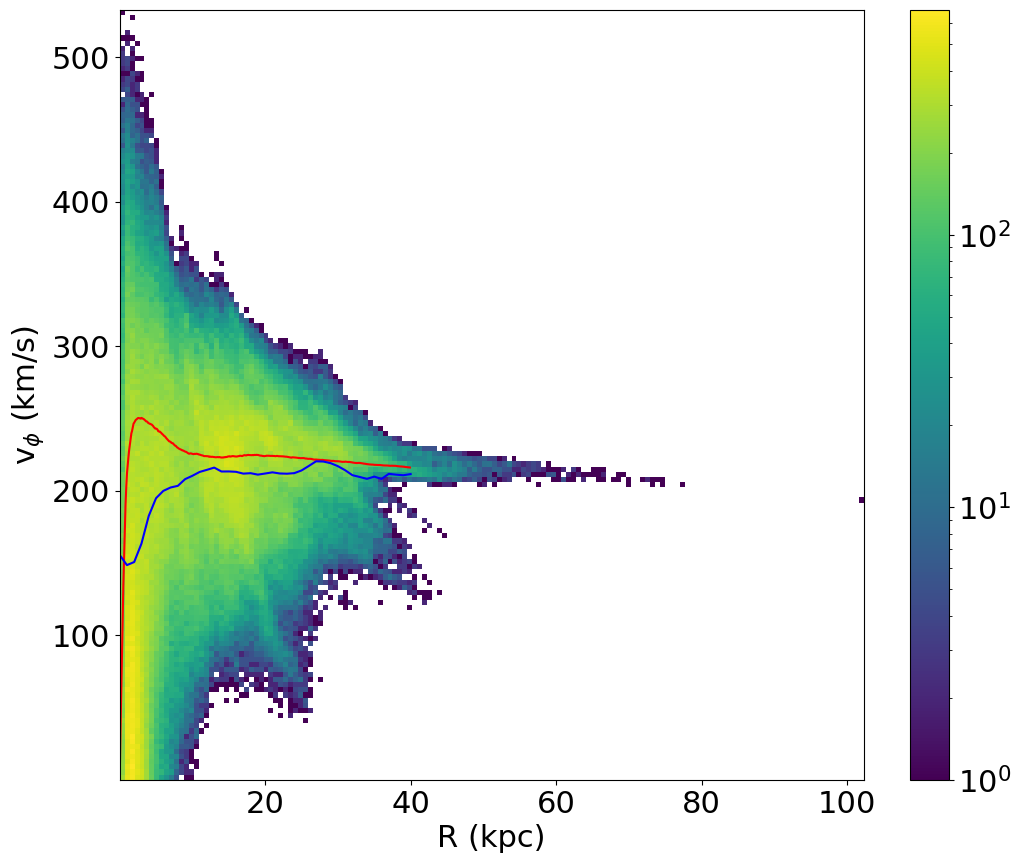

In [22]:
# Make a phase diagram
# MW Disk Velocity Field edge on.

fig = plt.figure(figsize=(12,10))
ax = plt.subplot(111)

# looking at MW edge on along x axis, vy is line of sight velocity

plt.hist2d(rho, np.abs(vphi), bins=150, norm=LogNorm())
#plt.scatter(rho, np.abs(vphi))
plt.colorbar()

# Add the circular velocity
plt.plot(r, Vcirc, color="red")
#plt.plot(-r, -Vcirc, color="red")


# Add the circular velocity
plt.plot(r2, v2, color="blue")
#plt.plot(-r2, -v2, color="blue")


# Add axis labels
plt.xlabel('R (kpc)', fontsize=22)
plt.ylabel(r'v$_\phi$ (km/s)', fontsize=22)

#set axis limits
#plt.ylim(0, 250)
#plt.xlim(0,30)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size


# Save file
plt.savefig('Lab9_RotationCurve_Vphi.png')


The mean cylindrical vphi deviates in the inner regions from the mass-derived rotation curve because of the bar. 

# Part C exploring Spiral Structure

In [23]:
# Determine the positions of the disk particles in 
# cylindrical coordinates. 
cyl_r = np.sqrt(rn[:,0]**2 + rn[:,1]**2) # radial
cyl_theta = np.arctan2(rn[:,1],rn[:,0])*180/np.pi # theta in degrees

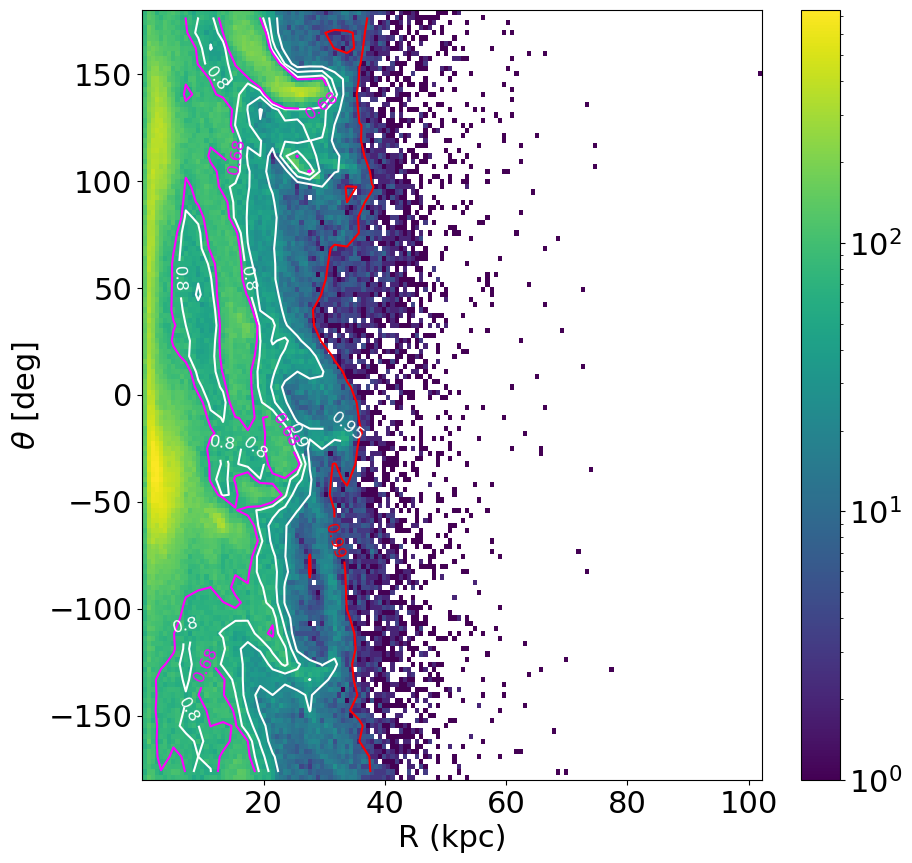

In [24]:
# Make a phase diagram
# R vs Theta

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# looking at MW edge on along x axis, vy is line of sight velocity

plt.hist2d(cyl_r, cyl_theta, bins=150, norm=LogNorm())
plt.colorbar()


# Add axis labels
plt.xlabel('R (kpc)', fontsize=22)
plt.ylabel(r'$\theta$ [deg]', fontsize=22)


# make the contour plot
# x pos, y pos, contour res, contour res, axis, colors for contours.
density_contour(cyl_r, cyl_theta, 50, 50, ax=ax, 
                colors=['red','white', 'white', 'white', 'magenta'])


#set axis limits
#plt.ylim(0,200)
#plt.xlim(-30,30)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size


# Save file
plt.savefig('Lab9_SpiralPhase.png')


# Part D:  Tracing Particles Across Different Snapshots

Trace particles from M31's bar in snap 0 to snap 5

In [25]:
# Create a COM of object for M31 Disk (particle type=2) Using Code from Homework 4
COMD_5 = CenterOfMass("M31_005_HighRes.txt",2)

In [26]:
# Compute COM of M31 using disk particles
COMP_5 = COMD_5.COM_P(0.1)
COMV_5 = COMD_5.COM_V(COMP_5[0],COMP_5[1],COMP_5[2])

In [27]:
# Determine positions of disk particles relative to COM 
xD_5 = COMD_5.x - COMP_5[0].value 
yD_5 = COMD_5.y - COMP_5[1].value 
zD_5 = COMD_5.z - COMP_5[2].value 

# total magnitude
rtot_5 = np.sqrt(xD_5**2 + yD_5**2 + zD_5**2)

# Determine velocities of disk particles relatiev to COM motion
vxD_5 = COMD_5.vx - COMV_5[0].value 
vyD_5 = COMD_5.vy - COMV_5[1].value 
vzD_5 = COMD_5.vz - COMV_5[2].value 

# total velocity 
vtot_5 = np.sqrt(vxD_5**2 + vyD_5**2 + vzD_5**2)

# Arrays for r and v 
r_5 = np.array([xD_5,yD_5,zD_5]).T # transposed for the Rotate Function later
v_5 = np.array([vxD_5,vyD_5,vzD_5]).T

In [28]:
# compute the rotated position and velocity vectors
rn_5, vn_5 = RotateFrame(r_5,v_5)

In [29]:
# Identify interesting particles in Snap 0
# Say in bar Theta = 130-150, R = 20-35

index = np.where((cyl_r < 2) & ((cyl_theta < -45) & (cyl_theta > -50))) 

Text(0, 0.5, 'y (kpc)')

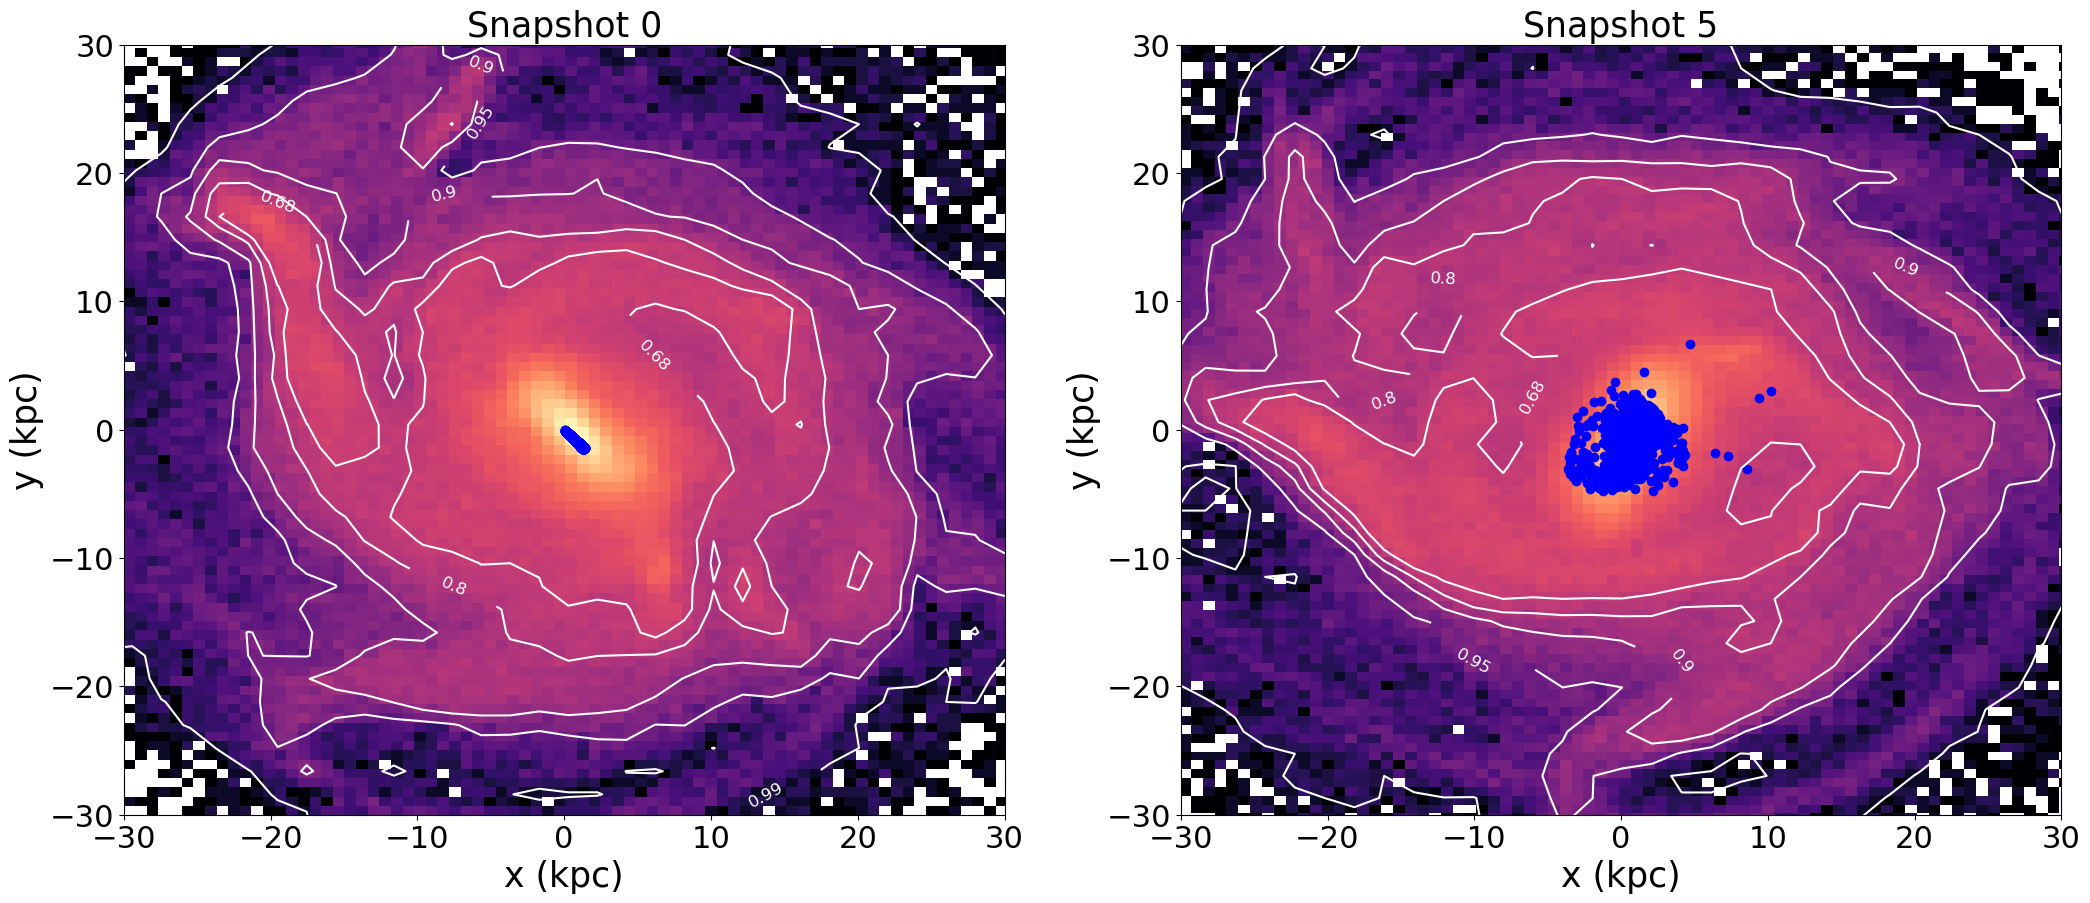

In [30]:
# Compare the Disk Structure At Snapshot0 to Snapshot 5
# Overplot the Bar Particles
    
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(25,10))    
        #   ax[0] for Snap 0
        #   ax[1] for Snap 5 
  

# Snapshot 0 

ax[0].hist2d(rn[:,0], rn[:,1], bins=200, norm=LogNorm(), cmap='magma')

density_contour(rn[:,0], rn[:,1], 80, 80, ax=ax[0], colors=['white'])

# Add Bar particles as a scatter 
ax[0].scatter(rn[index[0], 0], rn[index[0], 1], color='blue')


#set axis limits
ax[0].set_ylim(-30,30)
ax[0].set_xlim(-30,30)  

# Add axis labels
ax[0].set_xlabel('x (kpc)', fontsize=25)
ax[0].set_ylabel('y (kpc)', fontsize=25)

# Add Title 
ax[0].set_title('Snapshot 0', fontsize=25)


# Snapshot 5 

ax[1].hist2d(rn_5[:,0], rn_5[:,1], bins=200, norm=LogNorm(), cmap='magma')
density_contour(rn_5[:,0], rn_5[:,1], 80, 80, ax=ax[1], colors=['white'])

# overplot Bar particles identified in Snap 0 
ax[1].scatter(rn_5[index[0], 0], rn_5[index[0], 1], color='blue')


# Set axis limits
ax[1].set_xlim(-30,30)
ax[1].set_ylim(-30,30)

ax[1].set_title('Snapshot 5', fontsize=25)


# Add axis labels
ax[1].set_xlabel('x (kpc)', fontsize=25)
ax[1].set_ylabel('y (kpc)', fontsize=25)

  

In [ ]:
# Track particles with the highest resolution data only! 